# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [3]:
import jax

jax.config.update("jax_enable_x64", True)

In [4]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths with clear anisotropy.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True anisotropic smooth ----
    def f_true(x, y):
        # 1) Fast variation in x, slow in y
        term1 = 1.5 * np.sin(6 * np.pi * x) * np.cos(1 * np.pi * y)

        # 2) Anisotropic Gaussian bump: elongated + rotated
        x0, y0 = 0.65, 0.35
        a_x, a_y = 0.10, 0.35  # different length scales: much tighter in x
        rho = 0.7  # correlation -> rotated ellipse

        X = x - x0
        Y = y - y0
        quad = (X**2) / (a_x**2) + (Y**2) / (a_y**2) + 2 * rho * X * Y / (a_x * a_y)
        term2 = 2.0 * np.exp(-quad)

        # 3) Mild linear trend (mainly in y for additional anisotropy)
        term3 = 0.5 * y

        return term1 + term2 + term3

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [5]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.534281  0.287991
1  0.438878  0.761433 -0.434527 -0.649737
2  0.858598  0.903328  1.107858  1.722214
3  0.697368  0.720696  0.093873  0.544309
4  0.094177  0.963211 -0.977369 -1.080306


In [6]:
df_grid = gen_tp_data(n=5000, grid=True)

In [7]:
df_grid

,x,y,eta,z
0,0.000000,0.0,3.678865e-23,0.103675
1,0.014286,0.0,3.990553e-01,0.645541
2,0.028571,0.0,7.693489e-01,0.868480
3,0.042857,0.0,1.084192e+00,0.693245
4,0.057143,0.0,1.320893e+00,1.592500
...,...,...,...,...
5036,0.942857,1.0,1.820893e+00,1.616454
5037,0.957143,1.0,1.584192e+00,1.591152
5038,0.971429,1.0,1.269349e+00,1.251839
5039,0.985714,1.0,8.990553e-01,0.794860


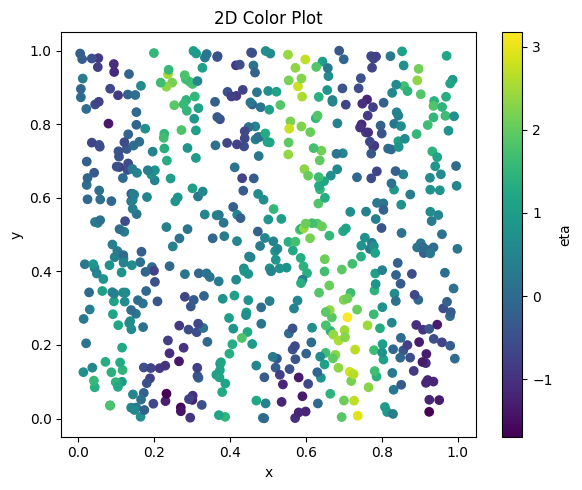

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

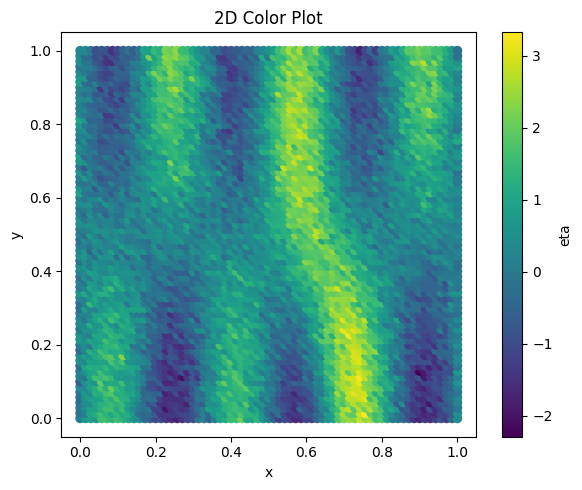

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

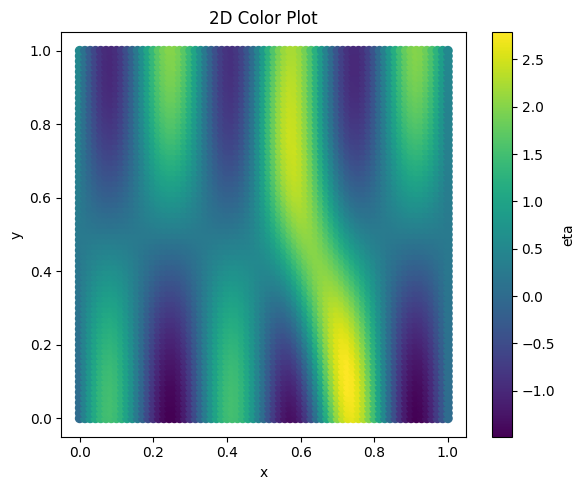

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [11]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [12]:
tb = gam.TermBuilder.from_df(df)

In [13]:
# loc += psx
# loc += psy

loc += tb.ps("x", k=15)
loc += tb.ps("y", k=15)

psx = tb.ps("x", k=12)
psy = tb.ps("y", k=12)
loc += tb.tx(psx, psy, scales_inference=gs.MCMCSpec(gs.HMCKernel))

### Build and plot model

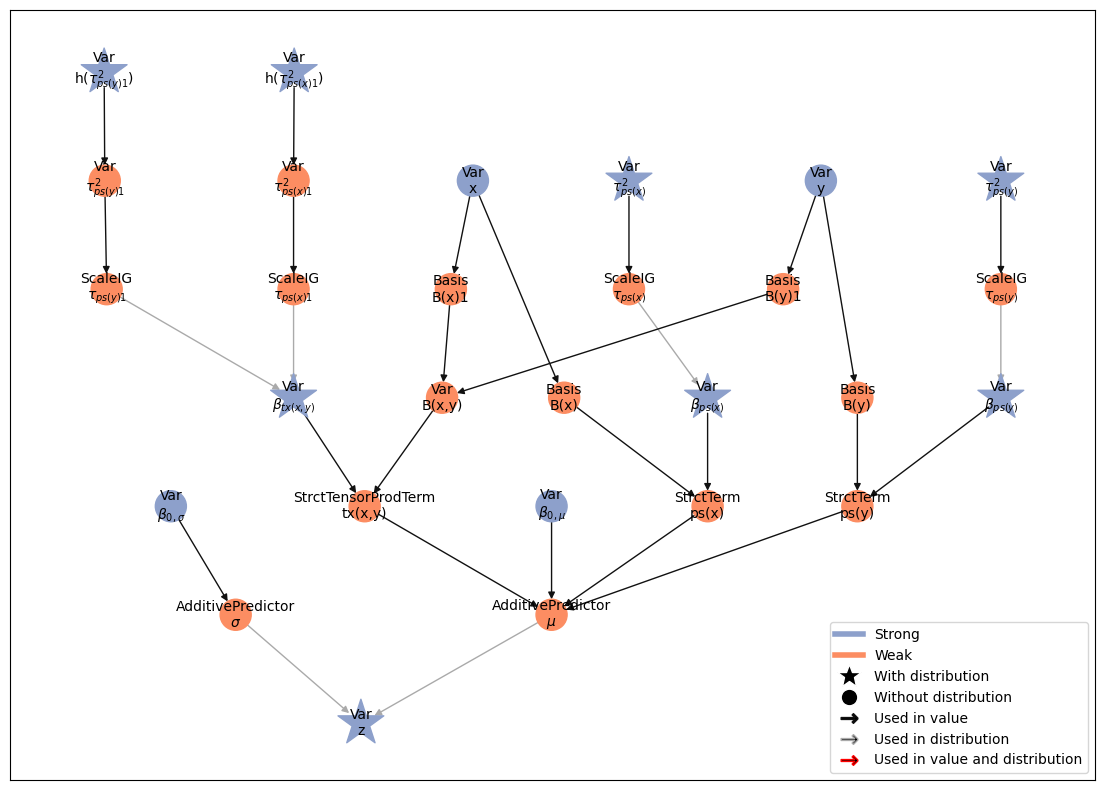

In [14]:
model = lsl.Model([z], to_float32=False)
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [15]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=3000,
        posterior_duration=2000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{tx(x,y)}$', 'h($\\tau_{ps(y)1}^2$)', 'h($\\tau_{ps(x)1}^2$)', '$\\beta_{ps(y)}$', '$\\tau_{ps(y)}^2$', '$\\beta_{ps(x)}$', '$\\tau_{ps(x)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:07<00:00,  1.03chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 13, 11, 14, 17 / 200 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 3, 7, 5, 8 / 200 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 951.52

### MCMC summary

In [16]:
summary = gs.Summary(results)

diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail"]]
    .groupby("variable", as_index=False)
    .agg(
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,"$\beta_{0,\mu}$",1266.667555,1266.667555,1497.302045,1497.302045,1.000840,1.000840
1,"$\beta_{0,\sigma}$",1210.535605,1210.535605,1371.764204,1371.764204,0.999189,0.999189
2,$\beta_{ps(x)}$,825.273639,1142.361852,1011.085034,1237.925214,1.003117,1.000651
3,$\beta_{ps(y)}$,581.063649,1094.462407,1035.737404,1237.428566,1.006686,1.002960
4,"$\beta_{tx(x,y)}$",90.496741,328.842156,117.481714,405.961932,1.034136,1.011446
5,$\tau_{ps(x)}^2$,1145.546074,1145.546074,1385.919432,1385.919432,0.999658,0.999658
6,$\tau_{ps(y)}^2$,948.591446,948.591446,1290.366448,1290.366448,1.003168,1.003168
7,h($\tau_{ps(x)1}^2$),1597.547643,1597.547643,1407.505877,1407.505877,1.000669,1.000669
8,h($\tau_{ps(y)1}^2$),52.263716,52.263716,122.125937,122.125937,1.049997,1.049997


In [17]:
summary.error_df()

count sample_size  \
kernel    error_code error_msg            phase                         
kernel_03 1          divergent transition warmup      530       12000   
                                          posterior     0        1600   
kernel_04 1          divergent transition warmup      136       12000   
                                          posterior     0        1600   

                                                    sample_size_total  \
kernel    error_code error_msg            phase                         
kernel_03 1          divergent transition warmup                12000   
                                          posterior              8000   
kernel_04 1          divergent transition warmup                12000   
                                          posterior              8000   

                                                     relative  
kernel    error_code error_msg            phase                
kernel_03 1          divergent transition warmup     0.044167  
                                          posterior       0.0  
kernel_04 1          divergent transition warmup     0.011333  
                                          posterior       0.0

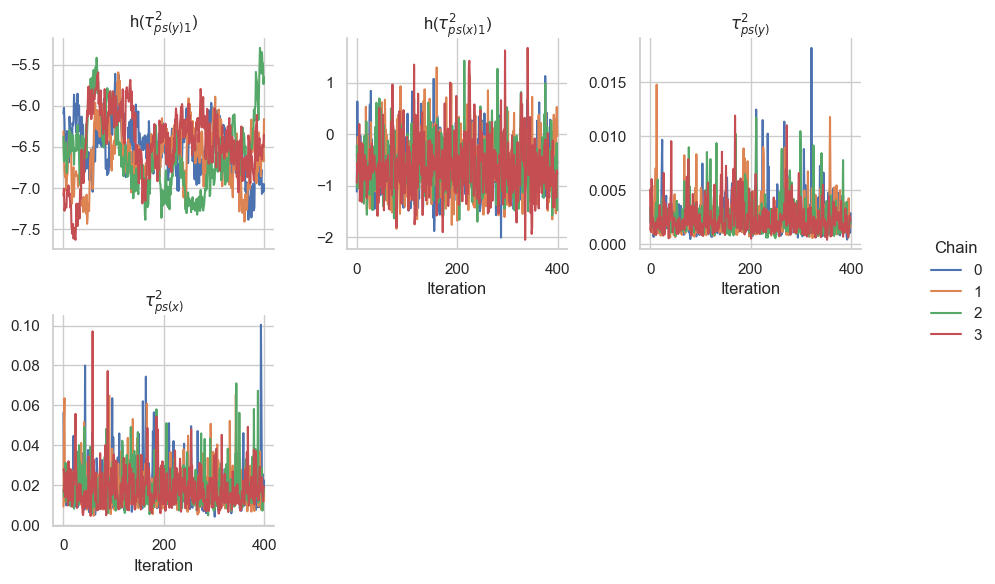

In [18]:
gs.plot_trace(results, [n for n in model.parameters if "tau" in n])

In [19]:
samples = results.get_posterior_samples()

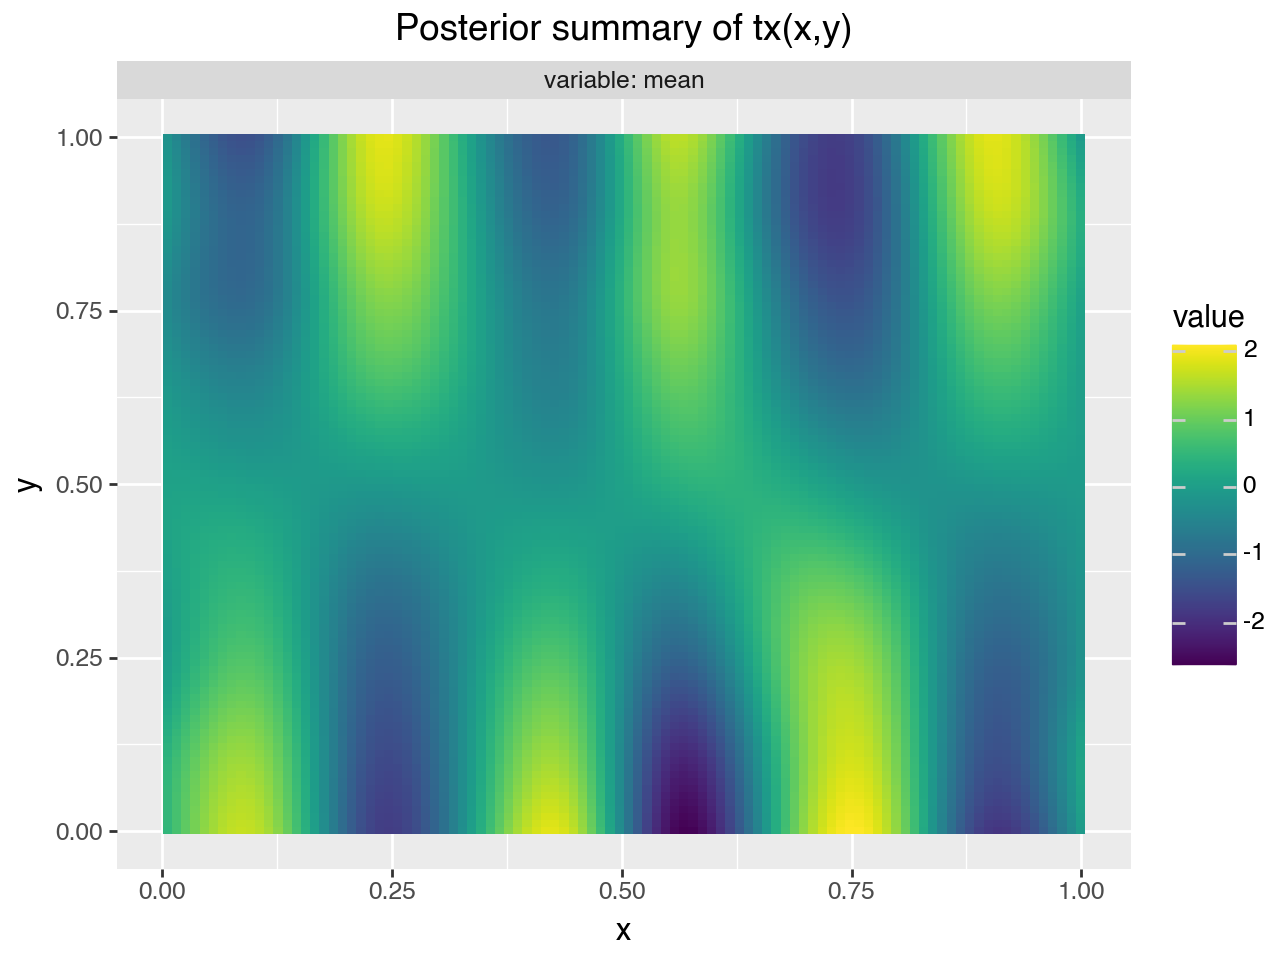

In [20]:
gam.plot_2d_smooth(model.vars["tx(x,y)"], samples, ngrid=100)

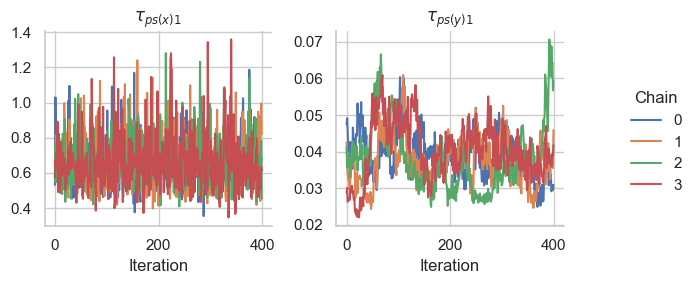

In [21]:
gs.plot_trace(
    model.predict(samples, predict=[s.name for s in model.vars["tx(x,y)"].scales])
)

### MCMC trace plots

## Predictions

In [22]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [23]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["tx(x,y)", "$\\mu$", "ps(x)", "ps(y)"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions, which=["mean", "quantiles"])
    .to_dataframe()
    .reset_index()
)

In [24]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [25]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,q_0.05,q_0.5,q_0.95,x,y
0,$\mu$,$\mu$[0],"(0,)",1600,0.327624,-0.920424,0.323993,1.502763,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",1600,0.663045,-0.321985,0.669925,1.598066,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",1600,0.980002,0.190979,0.993323,1.694508,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",1600,1.260804,0.611560,1.288040,1.857450,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",1600,1.487996,0.949103,1.505709,1.989815,0.057143,0.0


### Plot fitted functions

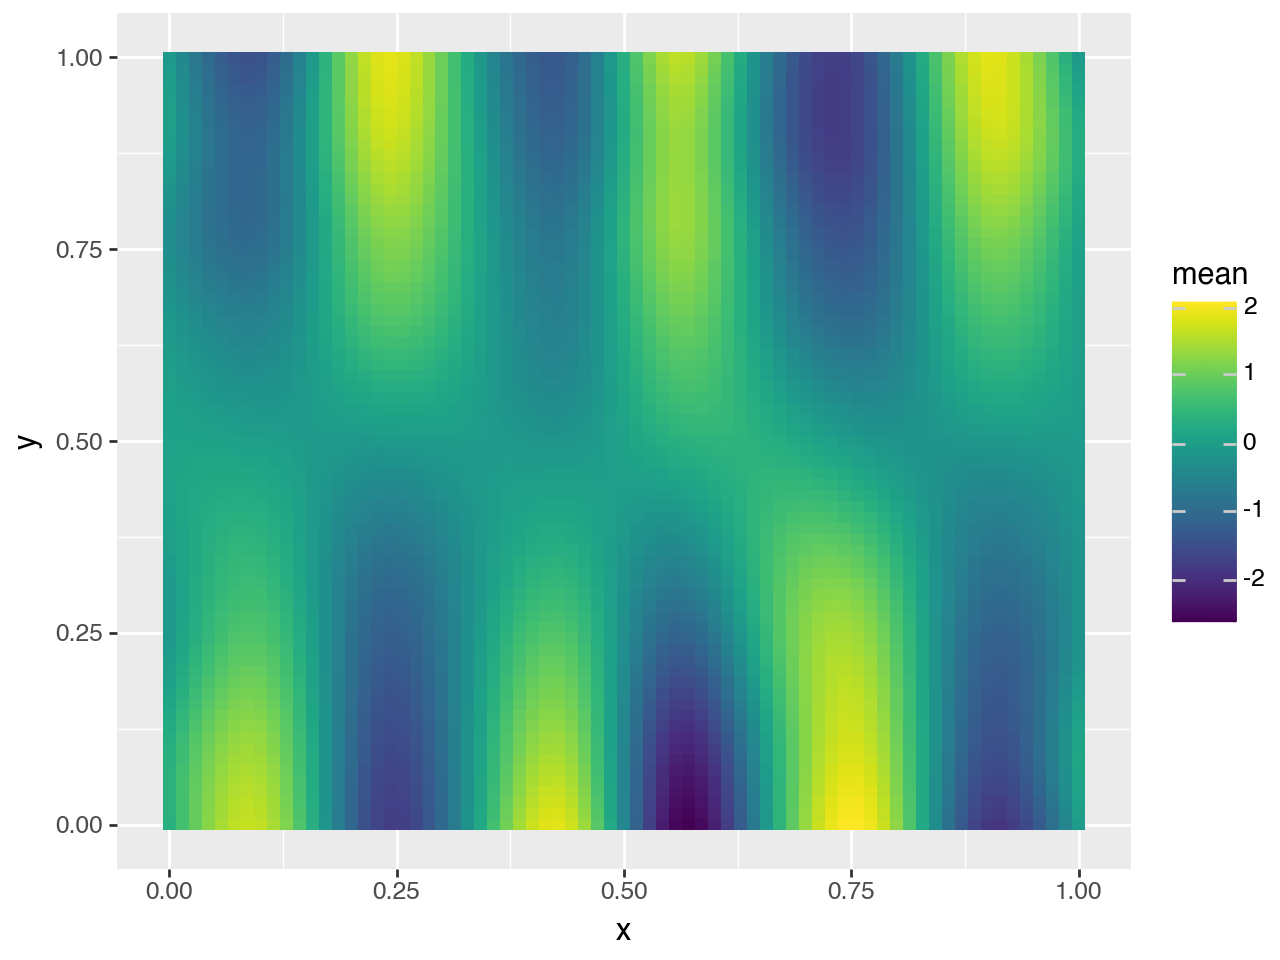

In [26]:
select = predictions_summary["variable"].isin(["tx(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

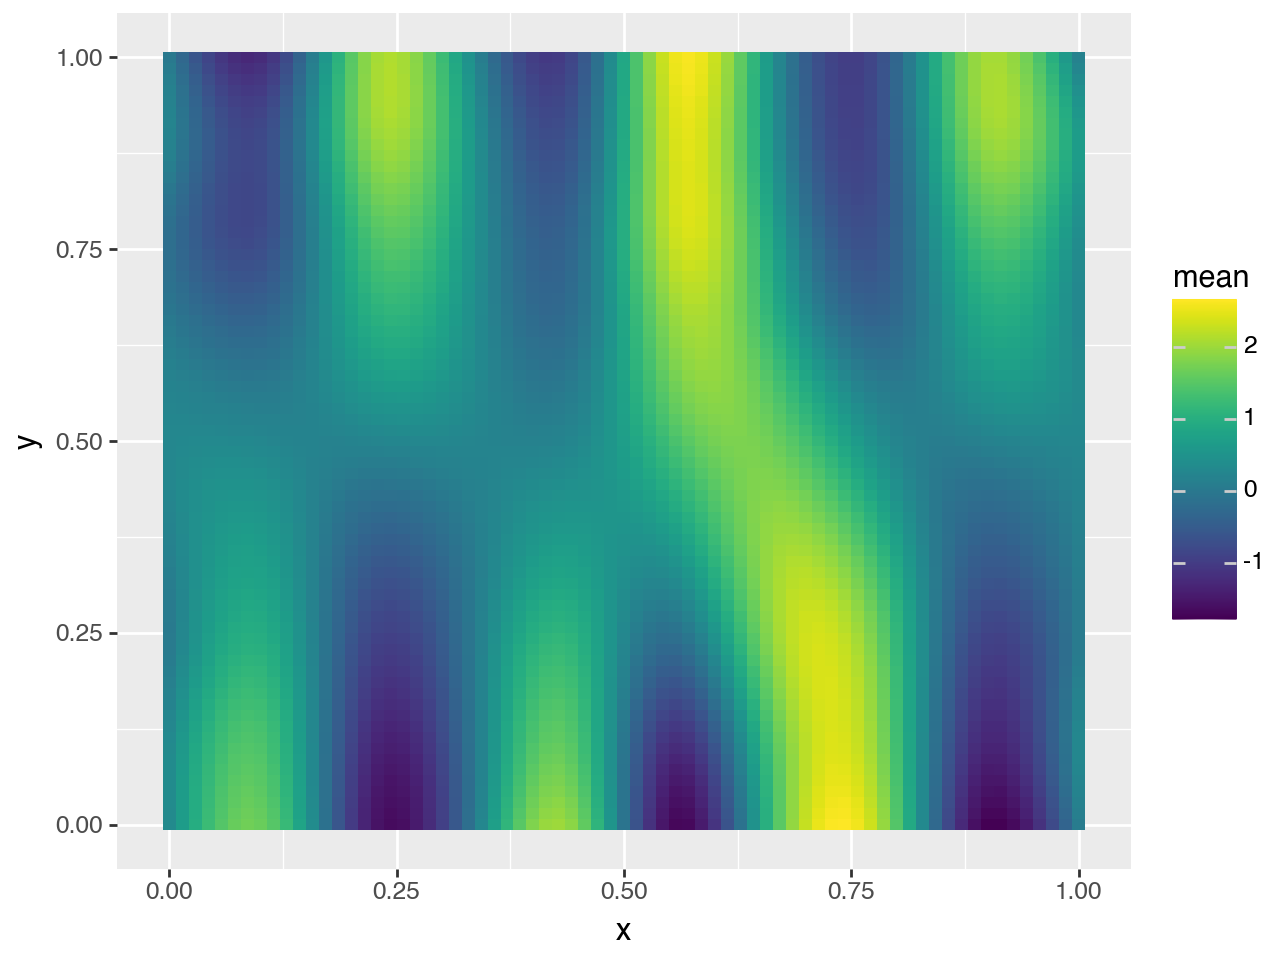

In [27]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

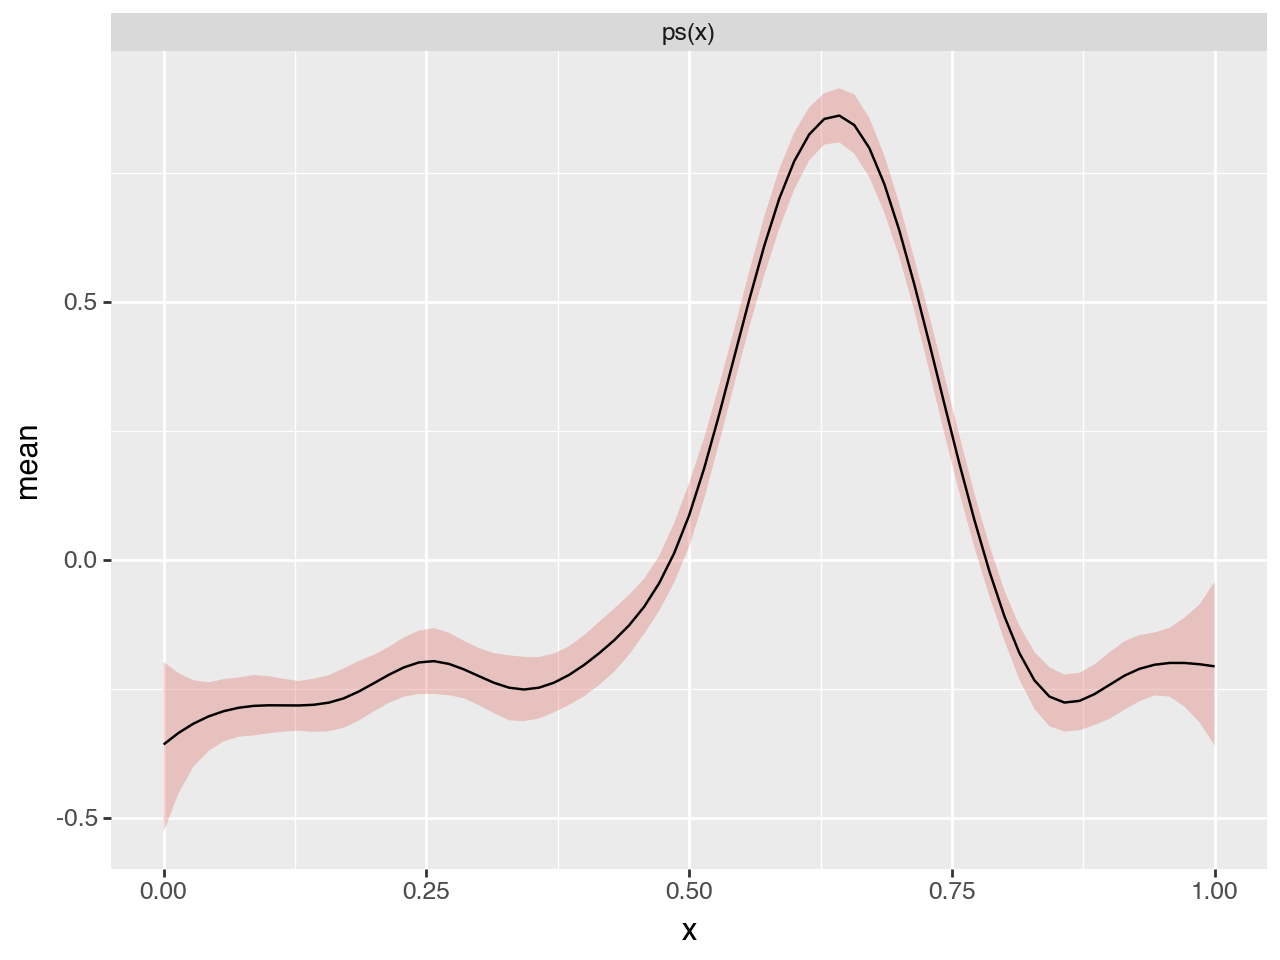

In [28]:
select = predictions_summary["variable"].isin(["ps(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

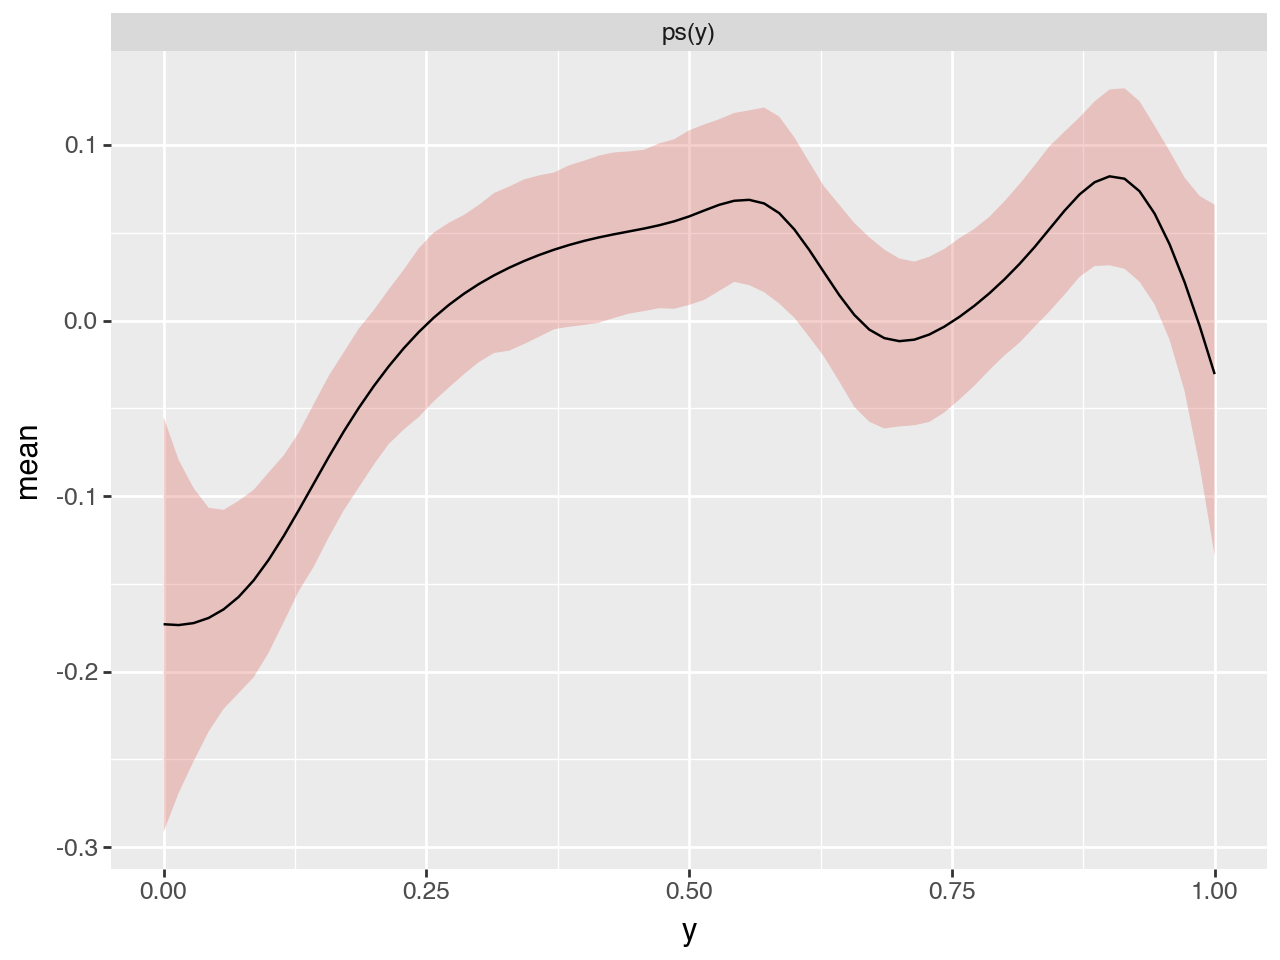

In [29]:
select = predictions_summary["variable"].isin(["ps(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)